# Fruit VAE with Inverse Autoregressive Flows (IAF) using `nflows` library

This notebook extends the CNN-based VAE for fruit images by incorporating **Inverse Autoregressive Flows (IAFs)** using the `nflows` library. This allows for a more flexible approximate posterior $q_\phi(z|x)$ and aims to improve the quality of generated fruit images.

Using a library like `nflows` simplifies the implementation of complex flow architectures and often provides more robust and optimized layers.

## 1. IAF and ELBO (Conceptual Recap - Same as before)

The core idea remains: transform a simple base Gaussian $z_0 \sim q_0(z_0|x)$ into $z_K$ using a sequence of IAF transformations. The ELBO and loss function structure are the same, but the calculation of $q_\phi(z_K|x)$ (and its log-determinant Jacobian sum) will now be handled by `nflows` layers.

$$ \log q_\phi(z_K|x) = \log q_0(z_0|x) - \sum_{k=1}^K \log|\det(z_k)| $$
where $\log|\det(z_k)|$ is the log absolute determinant of the Jacobian for the $k$-th flow layer.

## 2. Imports and Setup

In [9]:
!pip install nflows

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import glob
import imageio
import math

# --- Import nflows ---
from nflows.flows.base import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation # Or ReversePermutation
from nflows.distributions.normal import StandardNormal # For the base distribution in the flow

torch.manual_seed(42)
np.random.seed(42)

# --- Google Drive Setup (Same as before) ---
try:
    if os.path.exists('/content/drive/MyDrive/'):
        PROJECT_BASE_PATH = '/content/drive/MyDrive/SeminartalkVAEsNFs/' #<-- ADJUST IF NEEDED
    else: PROJECT_BASE_PATH = './SeminartalkVAEsNFs/'
except NameError: PROJECT_BASE_PATH = './SeminartalkVAEsNFs/'
print(f"Project base path: {PROJECT_BASE_PATH}")
if not os.path.exists(PROJECT_BASE_PATH): os.makedirs(PROJECT_BASE_PATH)

MODELS_DIR = os.path.join(PROJECT_BASE_PATH, 'models_iaf_nflows')
RESULTS_DIR = os.path.join(PROJECT_BASE_PATH, 'results_cnn_vae_fruit_iaf_nflows')
TRAIN_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'train2')
TEST_IMAGE_DIR = os.path.join(PROJECT_BASE_PATH, 'test2')
MODEL_NAME = 'iaf_nflows'

for dir_path in [MODELS_DIR, RESULTS_DIR, TRAIN_IMG_DIR,TEST_IMAGE_DIR]:
    if not os.path.exists(dir_path): os.makedirs(dir_path); print(f"Created: {dir_path}")

Project base path: /content/drive/MyDrive/SeminartalkVAEsNFs/


## 3. Hyperparameters

In [12]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 32
EPOCHS = 100 #50
LEARNING_RATE = 1e-4
LATENT_DIM = 64   # Dimensionality of z
IMG_CHANNELS = 3
IMG_HEIGHT = 96
IMG_WIDTH = 96

# IAF (nflows) specific parameters
NUM_IAF_BLOCKS = 4       # Number of IAF blocks (each block can be an AR transform + permutation)
IAF_HIDDEN_FEATURES = 128 # Hidden features in the nets of MaskedAffineAutoregressiveTransform
CONTEXT_FEATURES_ENCODER = 128 # Dimension of context vector h(x) from CNN encoder, fed to IAF
# Note: nflows autoregressive transforms can take a `context_features` argument.

Using device: cuda


## 4. Data Loading (Simplified to one fruit type for example)

In [13]:
# (CustomImageDataset class definition - same as before)
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, limit=None):
        self.img_dir = img_dir; all_img_paths = glob.glob(os.path.join(img_dir, '*.jpg')) + glob.glob(os.path.join(img_dir, '*.png')) + glob.glob(os.path.join(img_dir, '*.jpeg'))
        if limit and len(all_img_paths) > limit:
            actual_limit = min(limit, len(all_img_paths));
            if len(all_img_paths) > 0 : self.img_paths = np.random.choice(all_img_paths, actual_limit, replace=False).tolist()
            else: self.img_paths = []
            if self.img_paths: print(f"Limited dataset to {len(self.img_paths)} images from {img_dir}")
        else: self.img_paths = all_img_paths
        self.transform = transform
        if not self.img_paths: print(f"WARNING: No images found in {img_dir}.")
        elif self.img_paths: print(f"Found {len(self.img_paths)} images in {img_dir}")
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, idx):
        if not self.img_paths: return torch.zeros(IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH), 0
        img_path = self.img_paths[idx]; image = Image.open(img_path).convert('RGB')
        if self.transform: image = self.transform(image)
        return image, 0

transform = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH)), transforms.ToTensor()])

TRAIN_IMG_DIR = TRAIN_IMG_DIR
TEST_IMAGE_DIR = TEST_IMAGE_DIR
DATASET_LIMIT = None

train_dataset = CustomImageDataset(img_dir=TRAIN_IMG_DIR,transform=transform,limit=DATASET_LIMIT if DATASET_LIMIT else None)
test_dataset = CustomImageDataset(img_dir=TEST_IMAGE_DIR,transform=transform,limit=DATASET_LIMIT//5 if DATASET_LIMIT else None)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True if DEVICE.type=='cuda' else False)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True if DEVICE.type=='cuda' else False)

def show_tensor_images(image_tensor, num_images=4, nrow=2, show=True, save_path=None, title=None):
    # Determine size from tensor if not provided, assuming B, C, H, W
    # This function doesn't use the global IMG_HEIGHT, IMG_WIDTH directly for grid creation
    # but relies on the input tensor's shape.
    image_tensor = (image_tensor + 1) / 2 if image_tensor.min() < 0 else image_tensor
    image_unflat = image_tensor.detach().cpu().clamp(0, 1)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.figure(figsize=(nrow*2, (num_images//nrow)*2 if num_images > nrow else 4)) # Adjust figure size
    if title:
        plt.title(title)
    if show:
        plt.imshow(image_grid.permute(1, 2, 0).squeeze())
        plt.axis('off')
        plt.show()
    if save_path:
        save_image(image_grid, save_path)
        print(f"Saved image to {save_path}")

Found 1418 images in /content/drive/MyDrive/SeminartalkVAEsNFs/train2
Found 30 images in /content/drive/MyDrive/SeminartalkVAEsNFs/test2


## 5. VAE Model with `nflows` IAF

In [14]:
def create_iaf_flow(latent_dim, num_blocks, hidden_features_in_ar_net, context_features):
    """Helper to create a sequence of IAF blocks using nflows."""
    transforms_list = []
    for _ in range(num_blocks):
        transforms_list.append(RandomPermutation(features=latent_dim)) # Permute inputs to AR net
        transforms_list.append(MaskedAffineAutoregressiveTransform(
            features=latent_dim,
            hidden_features=hidden_features_in_ar_net,
            context_features=context_features, # Context from encoder
            num_blocks=2, # Number of residual blocks in the MADE network
            use_residual_blocks=True,
            random_mask=False, # Use standard autoregressive mask
            activation=F.relu,
            dropout_probability=0.0,
            use_batch_norm=False # Can add if needed
        ))
    # Base distribution for the flow is a standard normal (z0 will be transformed from this)
    # However, in VAE-IAF, q0 is N(mu_enc, sigma_enc). The flow transforms samples from this q0.
    # So, we just need the sequence of transforms.
    return nn.Sequential(*transforms_list) # nflows Flow object needs a base dist, but we just need transforms

class CNNVAE_nflows_IAF(nn.Module):
    def __init__(self, img_channels, latent_dim, img_height, img_width,
                 num_iaf_blocks, iaf_hidden_features, context_features_encoder):
        super(CNNVAE_nflows_IAF, self).__init__()
        self.latent_dim = latent_dim
        self.img_height = img_height
        self.img_width = img_width

        # === Encoder (CNN part + FCs for base Gaussian & context) ===
        enc_c1, enc_c2, enc_c3, enc_c4, enc_c5 = 32, 64, 128, 256, 512
        if img_height <= 64: enc_c1,enc_c2,enc_c3,enc_c4,enc_c5 = 32,64,128,256,256
        if img_height <= 32: enc_c1,enc_c2,enc_c3,enc_c4,enc_c5 = 32,64,128,128,128
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(img_channels, enc_c1, 4, 2, 1), nn.ReLU(True), nn.BatchNorm2d(enc_c1),
            nn.Conv2d(enc_c1, enc_c2, 4, 2, 1), nn.ReLU(True), nn.BatchNorm2d(enc_c2),
            nn.Conv2d(enc_c2, enc_c3, 4, 2, 1), nn.ReLU(True), nn.BatchNorm2d(enc_c3),
            nn.Conv2d(enc_c3, enc_c4, 4, 2, 1), nn.ReLU(True), nn.BatchNorm2d(enc_c4),
            nn.Conv2d(enc_c4, enc_c5, 4, 2, 1), nn.ReLU(True), nn.BatchNorm2d(enc_c5),
            nn.Flatten()
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1,img_channels,img_height,img_width)
            conv_out_shape = self._get_conv_output_shape(dummy_input)
            self.flattened_size_cnn = conv_out_shape[1]*conv_out_shape[2]*conv_out_shape[3]
            self.unflatten_channels, self.unflatten_height, self.unflatten_width = conv_out_shape[1:]

        self.fc_mu_z0 = nn.Linear(self.flattened_size_cnn, latent_dim)
        self.fc_log_var_z0 = nn.Linear(self.flattened_size_cnn, latent_dim)
        self.fc_context = nn.Linear(self.flattened_size_cnn, context_features_encoder)

        # IAF Layers using nflows (sequence of transforms)
        # The `nflows.Flow` object typically takes a base_dist.
        # Here, we use the transforms directly on samples from our encoder's base Gaussian.
        iaf_transforms = []
        for _ in range(num_iaf_blocks):
            iaf_transforms.append(RandomPermutation(features=latent_dim))
            iaf_transforms.append(MaskedAffineAutoregressiveTransform(
                features=latent_dim,
                hidden_features=iaf_hidden_features,
                context_features=context_features_encoder, # Context from encoder
                num_blocks=2, use_residual_blocks=True, random_mask=False,
                activation=torch.relu, dropout_probability=0.0, use_batch_norm=False
            ))
        self.iaf_flow_transforms = nn.Sequential(*iaf_transforms)

        # === Decoder (CNN part - same as before, takes z_K) ===
        self.decoder_fc = nn.Linear(latent_dim, self.unflatten_channels*self.unflatten_height*self.unflatten_width)
        dec_c1, dec_c2, dec_c3, dec_c4 = enc_c4, enc_c3, enc_c2, enc_c1
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(self.unflatten_channels,dec_c1,4,2,1),nn.LeakyReLU(0.2,True),nn.BatchNorm2d(dec_c1),
            nn.ConvTranspose2d(dec_c1,dec_c2,4,2,1),nn.LeakyReLU(0.2,True),nn.BatchNorm2d(dec_c2),
            nn.ConvTranspose2d(dec_c2,dec_c3,4,2,1),nn.LeakyReLU(0.2,True),nn.BatchNorm2d(dec_c3),
            nn.ConvTranspose2d(dec_c3,dec_c4,4,2,1),nn.LeakyReLU(0.2,True),nn.BatchNorm2d(dec_c4),
            nn.ConvTranspose2d(dec_c4,img_channels,4,2,1), nn.Sigmoid()
        )

    def _get_conv_output_shape(self, x_d): # Same as before
        mods = list(self.encoder_cnn.children());
        if isinstance(mods[-1],nn.Flatten): temp_enc = nn.Sequential(*mods[:-1])
        else: temp_enc = self.encoder_cnn
        return temp_enc(x_d).shape

    def encode_base_and_context(self, x):
        cnn_features = self.encoder_cnn(x)
        mu_z0 = self.fc_mu_z0(cnn_features)
        log_var_z0 = self.fc_log_var_z0(cnn_features)
        context = F.relu(self.fc_context(cnn_features)) # Context for IAF
        return mu_z0, log_var_z0, context

    def reparameterize_base(self, mu_z0, log_var_z0):
        std_z0 = torch.exp(0.5 * log_var_z0)
        eps = torch.randn_like(std_z0)
        return mu_z0 + eps * std_z0

    def encode(self, x):
        """
        Encodes input x to the parameters of the base Gaussian distribution q0(z0|x)
        and the context for the flows. For simple interpolation, we often just use mu_z0.
        Returns:
            mu_z0 (Tensor): Mean of the base Gaussian.
            log_var_z0 (Tensor): Log variance of the base Gaussian.
            context (Tensor): Context vector for IAF transforms.
        """
        mu_z0, log_var_z0, context = self.encode_base_and_context(x)
        return mu_z0, log_var_z0, context

    def apply_iaf_flows(self, z0, context):
        # The `nflows` MaskedAffineAutoregressiveTransform expects `inverse` for sampling z_k from z_0
        # (because it's an autoregressive transform, its inverse is fast for sampling).
        # For IAF, we want to compute z_k = f(z_0). The MaskedAffineAutoregressiveTransform
        # is $z_k = z_0 * exp(s) + t$ where s, t are AR functions of z_0 (or context).
        # The `forward` method of MaskedAffineAutoregressiveTransform does this: z_0 -> z_k
        # The `logabsdet` is part of the forward pass for this transform type.
        z_k = z0
        sum_log_abs_det = torch.zeros(z0.size(0), device=z0.device)
        # Iterate through the nn.Sequential of transforms
        # Each MaskedAffineAutoregressiveTransform layer and Permutation are separate modules in nn.Sequential
        for transform_layer in self.iaf_flow_transforms:
            if isinstance(transform_layer, MaskedAffineAutoregressiveTransform):
                z_k, log_det_j = transform_layer(z_k, context=context)
            else: # Permutation layer
                z_k, log_det_j = transform_layer(z_k) # Permutations have logabsdet too
            sum_log_abs_det += log_det_j
        return z_k, sum_log_abs_det

    def decode(self, z_k):
        h = F.leaky_relu(self.decoder_fc(z_k),0.2);
        h_r = h.view(-1,self.unflatten_channels,self.unflatten_height,self.unflatten_width)
        return self.decoder_cnn(h_r)

    def forward(self, x):
        mu_z0, log_var_z0, context = self.encode_base_and_context(x)
        z0 = self.reparameterize_base(mu_z0, log_var_z0)
        z_k, sum_log_abs_det = self.apply_iaf_flows(z0, context)
        recon_x = self.decode(z_k)
        return recon_x, mu_z0, log_var_z0, z0, z_k, sum_log_abs_det

model = CNNVAE_nflows_IAF(IMG_CHANNELS, LATENT_DIM, IMG_HEIGHT, IMG_WIDTH,
                          NUM_IAF_BLOCKS, IAF_HIDDEN_FEATURES, CONTEXT_FEATURES_ENCODER).to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

dummy_batch_iaf = torch.randn(2,IMG_CHANNELS,IMG_HEIGHT,IMG_WIDTH).to(DEVICE)
try:
    r,m0,lv0,z0,zk,sld = model(dummy_batch_iaf)
    print(f"Shapes: R:{r.shape}, M0:{m0.shape}, ZK:{zk.shape}, SLD:{sld.shape}")
except Exception as e:
    print(f"Error: {e}"); import traceback; traceback.print_exc()

Model parameters: 7619139
Shapes: R:torch.Size([2, 3, 96, 96]), M0:torch.Size([2, 64]), ZK:torch.Size([2, 64]), SLD:torch.Size([2])


## 6. Loss Function, Training, and Evaluation (Same logic as Planar/IAF from scratch)

In [15]:
# Loss function (`loss_function_iaf` using log_normal_diag, log_standard_normal) is identical
# to the one in the 'from scratch' IAF VAE notebook.
# Training loop (`train_iaf`, `test_iaf`) is also identical in logic.
# Make sure to use the correct model name for saving/loaEding: MODEL_NAME_NFLOWS_IAF

# Re-define log_normal_diag and log_standard_normal if not in scope
def log_normal_diag(x,mu,log_var,reduction='sum',dim=1):
    D=x.shape[dim];log_p=-0.5*D*np.log(2*np.pi)-0.5*torch.sum(log_var,dim=dim)-0.5*torch.sum(((x-mu)**2)/torch.exp(log_var),dim=dim)
    if reduction=='sum':return torch.sum(log_p)
    elif reduction=='mean':return torch.mean(log_p)
    else:return log_p
def log_standard_normal(x,reduction='sum',dim=1):
    D=x.shape[dim];log_p=-0.5*D*np.log(2*np.pi)-0.5*torch.sum(x**2,dim=dim)
    if reduction=='sum':return torch.sum(log_p)
    elif reduction=='mean':return torch.mean(log_p)
    else:return log_p

def loss_function_nflows_iaf(recon_x, x_original, mu_z0, log_var_z0, z0, z_k, sum_log_abs_det):
    MSE = F.mse_loss(recon_x, x_original, reduction='sum')
    log_q0_z0 = log_normal_diag(z0, mu_z0, log_var_z0, reduction='none', dim=1)
    log_p_zk = log_standard_normal(z_k, reduction='none', dim=1)
    kl_div_per_sample = log_q0_z0 - log_p_zk - sum_log_abs_det
    KLD = torch.sum(kl_div_per_sample)
    return MSE + KLD

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# (train_iaf, test_iaf, save_model, load_model, generation functions - adapt names and ensure they use RESULTS_DIR/MODELS_DIR)
# For generation with nflows, it's slightly different if the flow object itself is used:
# If self.iaf_flow was a nflows.Flow object: `z_k = self.iaf_flow.transform_to_noise(z0, context=context)` for z0 -> z_k ???
# No, it should be `z_k, log_det = self.iaf_flow_transforms(z0, context=context)` for z0 -> z_k
# For sampling from prior: z0_prior = N(0,I). Then z_k_gen, _ = model.apply_iaf_flows(z0_prior, dummy_context_for_gen)

def train_nflows_iaf(epoch, model, optimizer):
    model.train(); train_loss=0
    if not hasattr(train_loader,'dataset') or len(train_loader.dataset)==0: return 0
    for batch_idx,(data,_) in enumerate(train_loader):
        if data is None or data.numel()==0: continue
        data=data.to(DEVICE); optimizer.zero_grad()
        r,m0,lv0,z0,zk,sld = model(data)
        loss = loss_function_nflows_iaf(r,data,m0,lv0,z0,zk,sld)
        loss.backward(); train_loss+=loss.item(); optimizer.step()
        if batch_idx % (max(1,len(train_loader)//5))==0: print(f'Train nflowsIAF E:{epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)}] Loss:{loss.item()/len(data):.4f}')
    avg_l = train_loss/len(train_loader.dataset) if len(train_loader.dataset)>0 else 0
    print(f'====> nflowsIAF E:{epoch} Avg train loss:{avg_l:.4f}'); return avg_l

def test_nflows_iaf(epoch, model):
    model.eval(); test_loss=0
    if not hasattr(test_loader,'dataset') or len(test_loader.dataset)==0: return 0
    with torch.no_grad():
        for i,(data,_) in enumerate(test_loader):
            if data is None or data.numel()==0: continue
            data=data.to(DEVICE); r,m0,lv0,z0,zk,sld = model(data)
            test_loss += loss_function_nflows_iaf(r,data,m0,lv0,z0,zk,sld).item()
            if i==0 and (epoch%10==0 or epoch==EPOCHS):
                # (show_tensor_images call - same as before, use RESULTS_DIR)
                n=min(data.size(0),4); show_tensor_images(torch.cat([data[:n],r[:n]]),num_images=2*n,nrow=n,title=f"nflowsIAF E{epoch}",save_path=os.path.join(RESULTS_DIR,f'nflows_iaf_recon_e{epoch}.png'))
    avg_l = test_loss/len(test_loader.dataset) if len(test_loader.dataset)>0 else 0
    print(f'====> nflowsIAF Test loss:{avg_l:.4f}'); return avg_l

MODEL_NAME_NFLOWS_IAF = "fruit_vae_cnn_nflows_iaf"
# (Training loop execution - similar to before, call train_nflows_iaf, test_nflows_iaf)

## 7. Main Training Execution

In [16]:
train_losses_nflows_iaf, test_losses_nflows_iaf = [], []
print("\nStarting VAE with nflows IAF Training...")

if hasattr(train_loader, 'dataset') and len(train_loader.dataset) > 0:
    for epoch in range(1, EPOCHS + 1):
        train_l = train_nflows_iaf(epoch, model, optimizer)
        test_l = test_nflows_iaf(epoch, model)
        train_losses_nflows_iaf.append(train_l)
        test_losses_nflows_iaf.append(test_l)

        if epoch % 100 == 0 or epoch == EPOCHS:
            # Basic model state saving. For full resumability, save optimizer state and epoch too.
            torch.save(model.state_dict(), os.path.join(MODELS_DIR, f'{MODEL_NAME_NFLOWS_IAF}_e{epoch}.pth'))
            print(f"Saved nflows IAF model state at epoch {epoch} to {MODELS_DIR}")

        # Generate samples from prior
        if epoch % 5 == 0 or epoch == EPOCHS:
            with torch.no_grad():
                model.eval() # Ensure eval mode for generation
                z0_prior = torch.randn(16, LATENT_DIM).to(DEVICE)
                # For generation, context for IAF transforms needs to be handled.
                # Simplest: use a zero context or a learned constant context if designed that way.
                # Here, we need to pass a context of shape (16, CONTEXT_FEATURES_ENCODER)
                dummy_context_for_gen = torch.zeros(16, CONTEXT_FEATURES_ENCODER).to(DEVICE)
                # Note: A better approach for generation might involve a separate way to get context or train without it.

                zk_gen, _ = model.apply_iaf_flows(z0_prior, dummy_context_for_gen)
                gen_imgs = model.decode(zk_gen).cpu()
                show_tensor_images(gen_imgs, num_images=16, nrow=4, title=f"nflowsIAF Gen E{epoch}",
                                   save_path=os.path.join(RESULTS_DIR, f'{MODEL_NAME_NFLOWS_IAF}_sample_e{epoch}.png'))
    print("nflows IAF Training Finished.")
else:
    print("Skipping nflows IAF training as data could not be loaded or train_loader is empty.")

# (Plotting loss curves - same as before, use train_losses_nflows_iaf, etc.)
if train_losses_nflows_iaf:
    plt.figure(figsize=(10,5)); plt.plot(train_losses_nflows_iaf,label='Train'); plt.plot(test_losses_nflows_iaf,label='Test');
    plt.title('VAE nflows-IAF Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True);
    plt.savefig(os.path.join(RESULTS_DIR, f'{MODEL_NAME_NFLOWS_IAF}_loss.png')); plt.show();

Output hidden; open in https://colab.research.google.com to view.

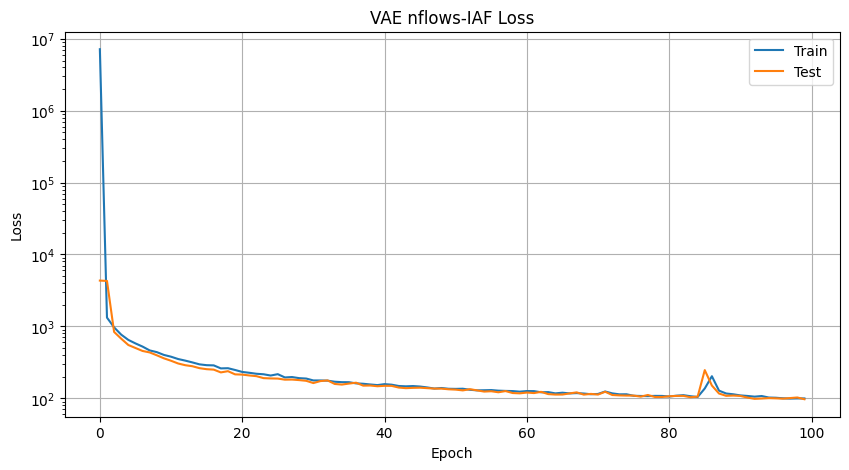

In [17]:
if train_losses_nflows_iaf:
    plt.figure(figsize=(10,5)); plt.plot(train_losses_nflows_iaf,label='Train'); plt.plot(test_losses_nflows_iaf,label='Test');
    plt.yscale('log')
    plt.title('VAE nflows-IAF Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True);
    plt.savefig(os.path.join(RESULTS_DIR, f'{MODEL_NAME_NFLOWS_IAF}_loss.png')); plt.show();

In [18]:
# (Assuming show_tensor_images, imageio, RESULTS_DIR, MODEL_NAME_NFLOWS_IAF, DEVICE are defined)

def interpolate_iaf_vae(
    model,
    img1_tensor, # Single image tensor (C, H, W) on CPU
    img2_tensor, # Single image tensor (C, H, W) on CPU
    num_steps=10,
    interpolate_mu_z0_only=True, # If True, decodes interpolated mu_z0.
                                 # If False, tries to flow interpolated mu_z0 (needs context handling).
    device=DEVICE,
    results_dir=RESULTS_DIR,
    model_name_prefix=MODEL_NAME_NFLOWS_IAF # Or pass explicitly
):
    model.eval()

    img1_batch = img1_tensor.unsqueeze(0).to(device)
    img2_batch = img2_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        mu_z0_1, _, context1 = model.encode(img1_batch) # Using the new encode method
        mu_z0_2, _, context2 = model.encode(img2_batch)

    interpolated_images = []
    alphas = torch.linspace(0, 1, num_steps, device=device)
    gif_frames = []

    for alpha_val in alphas:
        # Interpolate the means of the base distribution
        inter_mu_z0 = (1 - alpha_val) * mu_z0_1 + alpha_val * mu_z0_2

        z_to_decode = None
        if interpolate_mu_z0_only:
            # Option 1: Decode the interpolated mu_z0 directly.
            # This treats inter_mu_z0 as if it were z_k.
            # It's a simplification but often yields smooth visual results.
            z_to_decode = inter_mu_z0
        else:
            # Option 2: Pass interpolated mu_z0 through flows.
            # Context handling for interpolation is key here.
            # Simplest: interpolate contexts, or use an average context, or zero context.
            inter_context = (1 - alpha_val) * context1 + alpha_val * context2 # Interpolate contexts
            # Or: dummy_context_inter = torch.zeros_like(context1) # Zero context

            # We are passing inter_mu_z0 as if it's a z0 sample to the flow.
            # The flow transforms this point.
            inter_z_k, _ = model.apply_iaf_flows(inter_mu_z0, inter_context)
            z_to_decode = inter_z_k

        with torch.no_grad():
            decoded_img = model.decode(z_to_decode).cpu().squeeze(0)
        interpolated_images.append(decoded_img)

        # For GIF
        pil_img = transforms.ToPILImage()(decoded_img.clamp(0,1))
        gif_frames.append(np.array(pil_img))

    if not interpolated_images:
        print("No images generated for interpolation.")
        return None

    interpolated_images_tensor = torch.stack(interpolated_images)
    title = f"IAF VAE Interpolation ({num_steps} steps, mu_z0_only={interpolate_mu_z0_only})"
    plot_path = os.path.join(results_dir, f'{model_name_prefix}_interpolation_plot_mu0_{interpolate_mu_z0_only}.png')
    gif_path = os.path.join(results_dir, f'{model_name_prefix}_interpolation_mu0_{interpolate_mu_z0_only}.gif')

    show_tensor_images(interpolated_images_tensor, num_images=num_steps, nrow=num_steps, title=title, save_path=plot_path)

    if gif_frames:
        imageio.mimsave(gif_path, gif_frames, fps=max(1, num_steps // 2))
        print(f"Interpolation GIF saved to {gif_path}")

    return interpolated_images_tensor




Found 30 images in /content/drive/MyDrive/SeminartalkVAEsNFs/test2

Image 1 for interpolation:


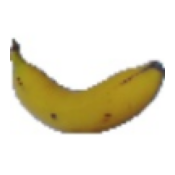

Image 2 for interpolation:


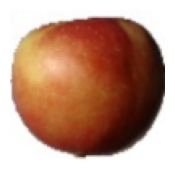


--- Interpolating mu_z0 and decoding directly ---


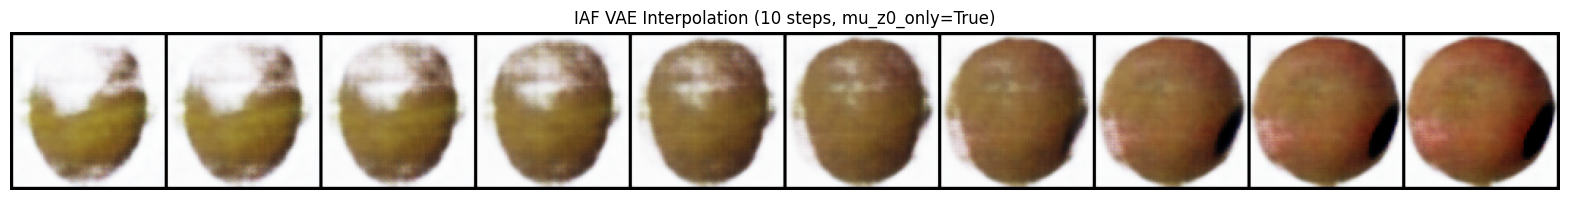

Saved image to /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit_iaf_nflows/fruit_vae_cnn_nflows_iaf_interpolation_plot_mu0_True.png
Interpolation GIF saved to /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit_iaf_nflows/fruit_vae_cnn_nflows_iaf_interpolation_mu0_True.gif

--- Interpolating mu_z0, flowing, then decoding ---


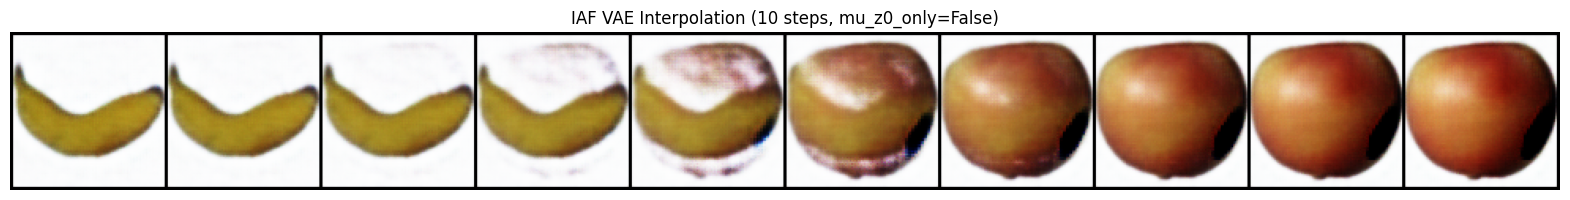

Saved image to /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit_iaf_nflows/fruit_vae_cnn_nflows_iaf_interpolation_plot_mu0_False.png
Interpolation GIF saved to /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit_iaf_nflows/fruit_vae_cnn_nflows_iaf_interpolation_mu0_False.gif


In [19]:
# --- Example Usage of the new interpolation function ---
model.eval() # Ensure model is in eval mode

test_dataset = CustomImageDataset(img_dir=TEST_IMAGE_DIR,transform=transform,limit=DATASET_LIMIT//5 if DATASET_LIMIT else None)
test_loader = DataLoader(test_dataset,batch_size=6,shuffle=True,num_workers=2,pin_memory=True if DEVICE.type=='cuda' else False)

if hasattr(test_loader, 'dataset') and len(test_loader.dataset) >= 2:
    try:
        data_iter = iter(test_loader)
        img1_data, _ = next(data_iter)
        img2_data, _ = next(data_iter)

        if img1_data is not None and img2_data is not None and \
           img1_data.size(0) > 0 and img2_data.size(0) > 0:

            img1_tensor_cpu = img1_data[0].cpu()
            img2_tensor_cpu = img2_data[0].cpu()

            print("\nImage 1 for interpolation:")
            show_tensor_images(img1_tensor_cpu.unsqueeze(0), num_images=1, nrow=1, show=True)
            print("Image 2 for interpolation:")
            show_tensor_images(img2_tensor_cpu.unsqueeze(0), num_images=1, nrow=1, show=True)

            # Option 1: Interpolate mu_z0 and decode directly
            print("\n--- Interpolating mu_z0 and decoding directly ---")
            interpolate_iaf_vae(model, img1_tensor_cpu, img2_tensor_cpu, num_steps=10, interpolate_mu_z0_only=True)

            # Option 2: Interpolate mu_z0, pass through flows, then decode
            print("\n--- Interpolating mu_z0, flowing, then decoding ---")
            interpolate_iaf_vae(model, img1_tensor_cpu, img2_tensor_cpu, num_steps=10, interpolate_mu_z0_only=False)
        else:
            print("Could not get two valid images for interpolation.")
    except StopIteration:
        print("Not enough data in test_loader for interpolation.")
    except Exception as e:
        print(f"Error during interpolation setup: {e}")
        import traceback
        traceback.print_exc()
else:
    print("DataLoader not available or has too few images for interpolation.")


--- Loading individual fruit datasets ---
Loading apples from /content/drive/MyDrive/SeminartalkVAEsNFs/apples...
Limited dataset to 50 images from /content/drive/MyDrive/SeminartalkVAEsNFs/apples
Found 50 images in /content/drive/MyDrive/SeminartalkVAEsNFs/apples
Loading bananas from /content/drive/MyDrive/SeminartalkVAEsNFs/bananas...
Limited dataset to 50 images from /content/drive/MyDrive/SeminartalkVAEsNFs/bananas
Found 50 images in /content/drive/MyDrive/SeminartalkVAEsNFs/bananas
Loading kiwis from /content/drive/MyDrive/SeminartalkVAEsNFs/kiwis...
Limited dataset to 50 images from /content/drive/MyDrive/SeminartalkVAEsNFs/kiwis
Found 50 images in /content/drive/MyDrive/SeminartalkVAEsNFs/kiwis

Example apple images:


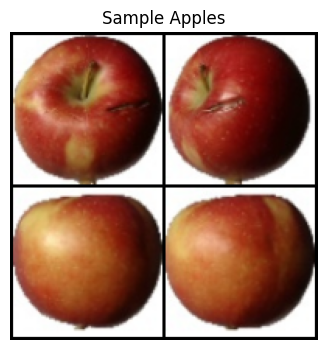

In [20]:
# Cell: Data Loading - Extended for specific fruit classes

# (CustomImageDataset class definition - same as before)
# (transform definition - same as before, using global IMG_HEIGHT, IMG_WIDTH)

# --- Define paths to your specific fruit image folders ---
# These should be inside PROJECT_BASE_PATH if you want them on Drive
APPLES_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'apples')
BANANAS_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'bananas')
KIWIS_IMG_DIR = os.path.join(PROJECT_BASE_PATH, 'kiwis')

# Create dummy fruit folders and images if they don't exist, for testing notebook flow
for fruit_dir_name in ['apples', 'bananas', 'kiwis']:
    fruit_dir_path = os.path.join(PROJECT_BASE_PATH, fruit_dir_name)
    if not os.path.exists(fruit_dir_path):
        os.makedirs(fruit_dir_path)
        print(f"Created dummy directory: {fruit_dir_path}")
        # Add a few dummy images
        if not os.listdir(fruit_dir_path): # Only if empty
            for i in range(3): # Create 3 dummy images per folder
                try:
                    dummy_pil_img = Image.fromarray(np.random.randint(0, 256, (IMG_HEIGHT+20, IMG_WIDTH+20, 3), dtype=np.uint8)) # Slightly larger to test resize
                    dummy_pil_img.save(os.path.join(fruit_dir_path, f'dummy_{fruit_dir_name}_{i}.png'))
                except Exception as e:
                    print(f"Error creating dummy fruit image in {fruit_dir_path}: {e}")


# --- Create Datasets and DataLoaders for each fruit ---
# You might want to adjust DATASET_LIMIT_PER_FRUIT based on your data and testing needs
DATASET_LIMIT_PER_FRUIT = 50 # Set to None to use all images, or a small number for quick tests

datasets_fruits = {}
dataloaders_fruits = {}
fruit_names = ["apples", "bananas", "kiwis"]
fruit_dirs = {
    "apples": APPLES_IMG_DIR,
    "bananas": BANANAS_IMG_DIR,
    "kiwis": KIWIS_IMG_DIR
}

print("\n--- Loading individual fruit datasets ---")
for fruit_name in fruit_names:
    img_dir = fruit_dirs[fruit_name]
    print(f"Loading {fruit_name} from {img_dir}...")
    current_dataset = CustomImageDataset(img_dir=img_dir, transform=transform, limit=DATASET_LIMIT_PER_FRUIT)
    datasets_fruits[fruit_name] = current_dataset
    if len(current_dataset) > 0:
        dataloaders_fruits[fruit_name] = DataLoader(
            current_dataset,
            batch_size=BATCH_SIZE, # Can use the global BATCH_SIZE or a specific one
            shuffle=False, # No need to shuffle for this encoding task
            num_workers=2,
            pin_memory=True if DEVICE.type == 'cuda' else False
        )
    else:
        print(f"WARNING: No images found for {fruit_name} in {img_dir}. Corresponding DataLoader will be empty.")
        # Create a dummy loader to prevent errors if a fruit class has no images
        dataloaders_fruits[fruit_name] = DataLoader(
            DummyDataset((IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH), 0), batch_size=BATCH_SIZE
        )

# Example: Show some apple images if loaded
if "apples" in dataloaders_fruits and len(dataloaders_fruits["apples"].dataset) > 0:
    try:
        example_apples, _ = next(iter(dataloaders_fruits["apples"]))
        if example_apples.numel() > 0:
            print("\nExample apple images:")
            show_tensor_images(example_apples, num_images=min(BATCH_SIZE, 4), nrow=2, title="Sample Apples")
    except StopIteration:
        print("Apple DataLoader is empty.")
    except Exception as e:
        print(f"Error showing example apples: {e}")

In [21]:
# Cell: Function to Get Average Latent Representations for a Class (for VAE-IAF)

def get_average_latent_representation_iaf(model, dataloader, device=DEVICE):
    """
    Encodes all images from a dataloader using VAE-IAF and computes the
    average mu_z0 and log_var_z0 of the base Gaussian distribution.
    Returns average_mu_z0, average_log_var_z0.
    """
    model.eval()
    all_mu_z0s = []
    all_log_var_z0s = []

    if not hasattr(dataloader, 'dataset') or len(dataloader.dataset) == 0:
        print("Warning: DataLoader is empty or invalid. Cannot compute average latent representation.")
        return None, None, None # Returning None for context too

    with torch.no_grad():
        for images, _ in dataloader:
            if images is None or images.numel() == 0: continue
            images = images.to(device)
            # Use the model's specific encode method that returns mu_z0, log_var_z0, and context
            mu_z0, log_var_z0, _ = model.encode(images) # We only need mu_z0 and log_var_z0 here
            all_mu_z0s.append(mu_z0.cpu())
            all_log_var_z0s.append(log_var_z0.cpu())

    if not all_mu_z0s:
        print("Warning: No images processed. Cannot compute average latent representation.")
        return None, None

    all_mu_z0s_tensor = torch.cat(all_mu_z0s, dim=0)
    all_log_var_z0s_tensor = torch.cat(all_log_var_z0s, dim=0)

    avg_mu_z0 = torch.mean(all_mu_z0s_tensor, dim=0, keepdim=True)
    avg_log_var_z0 = torch.mean(all_log_var_z0s_tensor, dim=0, keepdim=True)

    print(f"Computed average base latent: mu_z0_shape={avg_mu_z0.shape}, log_var_z0_shape={avg_log_var_z0.shape}")
    return avg_mu_z0, avg_log_var_z0

In [22]:
# %% [code]
# Cell: Latent Space Exploration and Class-Specific Generation for VAE-IAF

# --- Function to Get Average Latent Representations for a Class (for VAE-IAF) ---
def get_average_latent_representation_iaf(model, dataloader, device=DEVICE):
    """
    Encodes all images from a dataloader using VAE-IAF and computes the
    average mu_z0, log_var_z0 of the base Gaussian distribution, and average context.
    Returns average_mu_z0, average_log_var_z0, average_context.
    """
    model.eval() # Ensure model is in evaluation mode
    all_mu_z0s = []
    all_log_var_z0s = []
    all_contexts = []

    if not hasattr(dataloader, 'dataset') or len(dataloader.dataset) == 0:
        print("Warning: DataLoader is empty or invalid. Cannot compute average latent representation.")
        return None, None, None

    with torch.no_grad():
        for images, _ in dataloader:
            if images is None or images.numel() == 0:
                print("Skipping an empty or None batch in get_average_latent_representation_iaf.")
                continue
            images = images.to(device)
            mu_z0, log_var_z0, context = model.encode(images) # Assumes model.encode() returns these three
            all_mu_z0s.append(mu_z0.cpu())
            all_log_var_z0s.append(log_var_z0.cpu())
            all_contexts.append(context.cpu())

    if not all_mu_z0s:
        print("Warning: No images processed from DataLoader. Cannot compute average latent representation.")
        return None, None, None

    all_mu_z0s_tensor = torch.cat(all_mu_z0s, dim=0)
    all_log_var_z0s_tensor = torch.cat(all_log_var_z0s, dim=0)
    all_contexts_tensor = torch.cat(all_contexts, dim=0)

    avg_mu_z0 = torch.mean(all_mu_z0s_tensor, dim=0, keepdim=True)
    avg_log_var_z0 = torch.mean(all_log_var_z0s_tensor, dim=0, keepdim=True)
    avg_context = torch.mean(all_contexts_tensor, dim=0, keepdim=True)

    print(f"Computed average: mu_z0_shape={avg_mu_z0.shape}, log_var_z0_shape={avg_log_var_z0.shape}, context_shape={avg_context.shape}")
    return avg_mu_z0, avg_log_var_z0, avg_context


# --- Function for Class-Specific Generation (for VAE-IAF) ---
def generate_from_avg_latent_iaf(
    model,
    avg_mu_z0, avg_log_var_z0,
    num_samples=8,
    use_sampling_for_z0=True,
    use_flows=True,
    device=DEVICE,
    context_for_generation=None # Expected to be (1, context_dim) or (num_samples, context_dim)
):
    model.eval()
    avg_mu_z0 = avg_mu_z0.to(device)
    avg_log_var_z0 = avg_log_var_z0.to(device)

    generated_images_list = []

    # Prepare z0 samples (either one avg_mu_z0 repeated, or num_samples different z0s)
    z0_batch = None
    if use_sampling_for_z0:
        # For multiple samples, we need to expand avg_mu_z0 and avg_log_var_z0 to (num_samples, latent_dim)
        z0_batch = model.reparameterize_base(
            avg_mu_z0.repeat(num_samples, 1),
            avg_log_var_z0.repeat(num_samples, 1)
        )
    else: # Use avg_mu_z0 directly, repeated num_samples times
        z0_batch = avg_mu_z0.repeat(num_samples, 1)

    z_to_decode = None
    if use_flows:
        current_context_for_flow = None
        if context_for_generation is None:
            current_context_for_flow = torch.zeros(num_samples, model.context_features_encoder, device=device)
        elif isinstance(context_for_generation, torch.Tensor):
            context_for_generation = context_for_generation.to(device)
            if context_for_generation.size(0) == 1 and num_samples > 1:
                current_context_for_flow = context_for_generation.repeat(num_samples, 1)
            elif context_for_generation.size(0) == num_samples:
                current_context_for_flow = context_for_generation
            else:
                print(f"Error: Batch size mismatch for context ({context_for_generation.size(0)}) and z0 ({num_samples}). Using zero context.")
                current_context_for_flow = torch.zeros(num_samples, model.context_features_encoder, device=device)
        else:
            print(f"Error: 'context_for_generation' was not None or Tensor (got {type(context_for_generation)}). Using zero context.")
            current_context_for_flow = torch.zeros(num_samples, model.context_features_encoder, device=device)

        with torch.no_grad():
            z_k_batch, _ = model.apply_iaf_flows(z0_batch, current_context_for_flow)
        z_to_decode = z_k_batch
    else:
        z_to_decode = z0_batch # Decode z0_batch directly (bypassing flows)

    with torch.no_grad():
        decoded_imgs_batch = model.decode(z_to_decode).cpu() # (num_samples, C, H, W)

    # No need for a loop here if we process as a batch
    # for i in range(decoded_imgs_batch.size(0)):
    #    generated_images_list.append(decoded_imgs_batch[i])
    # return torch.stack(generated_images_list) if generated_images_list else torch.empty(0, IMG_CHANNELS, IMG_HEIGHT, IMG_WIDTH)
    return decoded_imgs_batch


# --- Function for Interpolation between Average Latents (for VAE-IAF) ---
def interpolate_between_average_latents_iaf(
    model,
    mu_z0_1, log_var_z0_1, context_1, # For fruit 1's base distribution & context
    mu_z0_2, log_var_z0_2, context_2, # For fruit 2's base distribution & context
    num_steps=10,
    use_flows_for_interp=True,
    device=DEVICE,
    output_gif_path=None,
    output_plot_path=None,
    model_name_prefix="iaf_interp" # Default prefix
):
    model.eval()
    mu_z0_1, mu_z0_2 = mu_z0_1.to(device), mu_z0_2.to(device)
    context_1, context_2 = context_1.to(device), context_2.to(device)

    interpolated_images_list = []
    alphas = torch.linspace(0, 1, num_steps, device=device) # (num_steps)
    gif_frames = []

    # Expand mu_z0 and context to be (num_steps, dim) for batched interpolation
    mu_z0_1_expanded = mu_z0_1.repeat(num_steps, 1) # (num_steps, latent_dim)
    mu_z0_2_expanded = mu_z0_2.repeat(num_steps, 1) # (num_steps, latent_dim)
    context_1_expanded = context_1.repeat(num_steps, 1) # (num_steps, context_dim)
    context_2_expanded = context_2.repeat(num_steps, 1) # (num_steps, context_dim)

    # alphas need to be (num_steps, 1) for broadcasting with (num_steps, latent_dim)
    alphas_expanded = alphas.unsqueeze(1) # (num_steps, 1)

    inter_mu_z0_batch = (1 - alphas_expanded) * mu_z0_1_expanded + alphas_expanded * mu_z0_2_expanded

    z_to_decode_batch = None
    if use_flows_for_interp:
        inter_context_batch = (1 - alphas_expanded) * context_1_expanded + alphas_expanded * context_2_expanded
        with torch.no_grad():
            inter_z_k_batch, _ = model.apply_iaf_flows(inter_mu_z0_batch, inter_context_batch)
        z_to_decode_batch = inter_z_k_batch
    else:
        z_to_decode_batch = inter_mu_z0_batch

    with torch.no_grad():
        decoded_imgs_batch = model.decode(z_to_decode_batch).cpu() # (num_steps, C, H, W)

    if output_gif_path:
        for i in range(decoded_imgs_batch.size(0)):
            pil_img = transforms.ToPILImage()(decoded_imgs_batch[i].clamp(0,1))
            gif_frames.append(np.array(pil_img))

    flow_str = "flowed" if use_flows_for_interp else "direct_mu_z0"
    title = f"IAF Interpolation (avg_mu_z0, {flow_str}, {num_steps} steps)"
    actual_plot_path = output_plot_path or os.path.join(RESULTS_DIR, f'{model_name_prefix}_avg_latent_interp_{flow_str}.png')
    show_tensor_images(decoded_imgs_batch, num_images=num_steps, nrow=min(num_steps, 10), title=title, save_path=actual_plot_path) # Adjust nrow

    if output_gif_path and gif_frames:
        actual_gif_path = output_gif_path or os.path.join(RESULTS_DIR, f'{model_name_prefix}_avg_latent_interp_{flow_str}.gif')
        try:
            imageio.mimsave(actual_gif_path, gif_frames, fps=max(1, num_steps // 2))
            print(f"Interpolation GIF saved to {actual_gif_path}")
        except Exception as e:
            print(f"Error saving GIF: {e}. `imageio` might need `pip install imageio[ffmpeg]` or `pip install imageio[pyav]` for some formats.")


    return decoded_imgs_batch


# --- Main Latent Space Exploration for Fruit Classes (using VAE-IAF) ---
def run_fruit_class_exploration_iaf(model, dataloaders_fruits, fruit_names, device, results_dir, model_name_prefix):
    model.eval() # Ensure model is in evaluation mode
    print("\n--- Exploring IAF Latent Space for Fruit Classes ---")

    average_base_latents = {} # Stores avg_mu_z0, avg_log_var_z0, avg_context

    for fruit_name in fruit_names:
        print(f"\nProcessing {fruit_name}...")
        if fruit_name in dataloaders_fruits and \
           hasattr(dataloaders_fruits[fruit_name], 'dataset') and \
           len(dataloaders_fruits[fruit_name].dataset) > 0:

            avg_mu_z0, avg_log_var_z0, avg_context = get_average_latent_representation_iaf(
                model, dataloaders_fruits[fruit_name], device
            )
            if avg_mu_z0 is not None and avg_context is not None:
                average_base_latents[fruit_name] = {
                    'mu_z0': avg_mu_z0,
                    'log_var_z0': avg_log_var_z0,
                    'context': avg_context
                }

                # --- Generate images from this average base latent representation ---
                title_prefix = f"IAF Gen: {fruit_name.capitalize()}"
                save_prefix = f'{model_name_prefix}_gen_avg_{fruit_name}'

                print(f"  Generating (sample z0, flow with avg_context, decode):")
                gen_flowed_ctx = generate_from_avg_latent_iaf(
                    model, avg_mu_z0, avg_log_var_z0, num_samples=8,
                    use_sampling_for_z0=True, use_flows=True, context_for_generation=avg_context, device=device
                )
                if gen_flowed_ctx.numel() > 0:
                     show_tensor_images(gen_flowed_ctx, num_images=8, nrow=4,
                                       title=f"{title_prefix} (Sample z0, Flowed w/ AvgCtx)",
                                       save_path=os.path.join(results_dir, f'{save_prefix}_flowed_ctx.png'))

                print(f"  Generating (avg_mu_z0, flow with avg_context, decode):")
                gen_mu_flowed_ctx = generate_from_avg_latent_iaf(
                    model, avg_mu_z0, avg_log_var_z0, num_samples=1,
                    use_sampling_for_z0=False, use_flows=True, context_for_generation=avg_context, device=device
                )
                if gen_mu_flowed_ctx.numel() > 0:
                    show_tensor_images(gen_mu_flowed_ctx, num_images=1, nrow=1,
                                       title=f"{title_prefix} (Avg_mu_z0, Flowed w/ AvgCtx)",
                                       save_path=os.path.join(results_dir, f'{save_prefix}_mu_flowed_ctx.png'))

                print(f"  Generating (avg_mu_z0 directly decoded, no flow):")
                gen_mu_direct = generate_from_avg_latent_iaf(
                    model, avg_mu_z0, avg_log_var_z0, num_samples=1,
                    use_sampling_for_z0=False, use_flows=False, device=device # context not needed if use_flows=False
                )
                if gen_mu_direct.numel() > 0:
                    show_tensor_images(gen_mu_direct, num_images=1, nrow=1,
                                       title=f"{title_prefix} (Avg_mu_z0, No Flow)",
                                       save_path=os.path.join(results_dir, f'{save_prefix}_mu_noflow.png'))
            else:
                print(f"Could not compute average base latent for {fruit_name}.")
        else:
            print(f"Skipping {fruit_name} as its DataLoader is empty or invalid.")

    # --- Interpolations between average fruit base latents (mu_z0) ---
    fruit_pairs_to_interpolate = [("apples", "bananas"), ("apples", "kiwis"), ("bananas", "kiwis")]
    for fruit1_name, fruit2_name in fruit_pairs_to_interpolate:
        if fruit1_name in average_base_latents and fruit2_name in average_base_latents:
            print(f"\nInterpolating {fruit1_name.capitalize()} & {fruit2_name.capitalize()} (decoding interpolated mu_z0 directly):")
            interpolate_between_average_latents_iaf(
                model,
                average_base_latents[fruit1_name]['mu_z0'], average_base_latents[fruit1_name]['log_var_z0'], average_base_latents[fruit1_name]['context'],
                average_base_latents[fruit2_name]['mu_z0'], average_base_latents[fruit2_name]['log_var_z0'], average_base_latents[fruit2_name]['context'],
                num_steps=10, use_flows_for_interp=False, device=device, model_name_prefix=f"{model_name_prefix}_{fruit1_name}_{fruit2_name}"
            )
            print(f"\nInterpolating {fruit1_name.capitalize()} & {fruit2_name.capitalize()} (flowing interpolated mu_z0 then decoding):")
            interpolate_between_average_latents_iaf(
                model,
                average_base_latents[fruit1_name]['mu_z0'], average_base_latents[fruit1_name]['log_var_z0'], average_base_latents[fruit1_name]['context'],
                average_base_latents[fruit2_name]['mu_z0'], average_base_latents[fruit2_name]['log_var_z0'], average_base_latents[fruit2_name]['context'],
                num_steps=10, use_flows_for_interp=True, device=device, model_name_prefix=f"{model_name_prefix}_{fruit1_name}_{fruit2_name}"
            )
        else:
            print(f"Skipping interpolation for {fruit1_name}-{fruit2_name}, one or both average latents not available.")

    print("\n--- IAF Fruit Class Latent Space Exploration Finished ---")


# --- Example: How to call run_fruit_class_exploration_iaf ---
#This would be at the end of your notebook, after model is trained/loaded and dataloaders_fruits is populated.

#Ensure your actual trained VAE-IAF model is assigned to 'model' variable
#model = CNNVAE_nflows_IAF(...)
#model.load_state_dict(torch.load(PATH_TO_YOUR_TRAINED_MODEL_WEIGHTS, map_location=DEVICE))
#model.to(DEVICE)
model.eval()

#Ensure dataloaders_fruits is populated correctly (from your data loading cell)
fruit_names = ["apples", "bananas", "kiwis"] # Or whatever your classes are

if 'model' in locals() and model is not None and \
   'dataloaders_fruits' in locals() and dataloaders_fruits and \
   'fruit_names' in locals() and fruit_names:

   print("\nStarting fruit class exploration with a loaded/trained model...")
   run_fruit_class_exploration_iaf(
       model=model,
       dataloaders_fruits=dataloaders_fruits,
       fruit_names=fruit_names,
       device=DEVICE,
       results_dir=RESULTS_DIR, # Defined in your setup
       model_name_prefix=MODEL_NAME_NFLOWS_IAF # Defined in your setup
   )
else:
   print("\nSkipping fruit class exploration: Model, dataloaders_fruits, or fruit_names not defined.")
   print("Make sure to train or load a model and set up your fruit-specific DataLoaders first.")

Output hidden; open in https://colab.research.google.com to view.

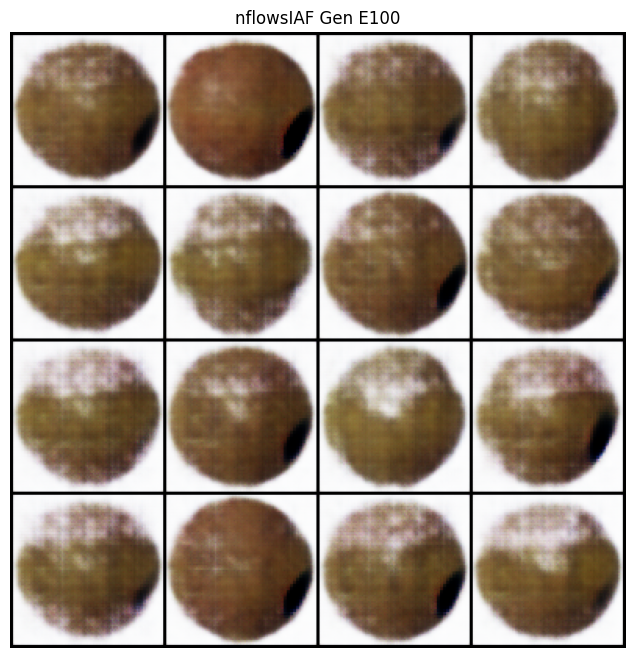

Saved image to /content/drive/MyDrive/SeminartalkVAEsNFs/results_cnn_vae_fruit_iaf_nflows/fruit_vae_cnn_nflows_iaf_sample_e.png


In [43]:
model.eval() # Ensure eval mode for generation
z0_prior = torch.randn(16, LATENT_DIM).to(DEVICE)
# For generation, context for IAF transforms needs to be handled.
# Simplest: use a zero context or a learned constant context if designed that way.
# Here, we need to pass a context of shape (16, CONTEXT_FEATURES_ENCODER)
dummy_context_for_gen = torch.zeros(16, CONTEXT_FEATURES_ENCODER).to(DEVICE)
# Note: A better approach for generation might involve a separate way to get context or train without it.

zk_gen, _ = model.apply_iaf_flows(z0_prior, dummy_context_for_gen)
gen_imgs = model.decode(zk_gen).cpu()
show_tensor_images(gen_imgs, num_images=16, nrow=4, title=f"nflowsIAF Gen E{epoch}",
                    save_path=os.path.join(RESULTS_DIR, f'{MODEL_NAME_NFLOWS_IAF}_sample_e.png'))